In [42]:
import os
import zipfile
import urllib.request
import glob
import cv2
import numpy as np
import random
import torchvision.transforms as transforms
from PIL import Image
from sklearn import preprocessing, metrics
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from copy import deepcopy
import numpy as np
from numpy import newaxis
import struct
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import time
import json
import codecs
from tqdm import tqdm
import torch
import locale
import torch
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from sklearn import metrics
import matplotlib.pyplot as plt
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix

In [2]:
!kaggle datasets download -d nodoubttome/skin-cancer9-classesisic
!unzip -q skin-cancer9-classesisic.zip
!rm -r skin-cancer9-classesisic.zip

Dataset URL: https://www.kaggle.com/datasets/nodoubttome/skin-cancer9-classesisic
License(s): other
100%|███████████████████████████████████████▉| 784M/786M [00:20<00:00, 41.8MB/s]
100%|████████████████████████████████████████| 786M/786M [00:20<00:00, 41.0MB/s]


In [3]:
import shutil

old_path = "/kaggle/working/Skin cancer ISIC The International Skin Imaging Collaboration"
new_path = "/content/data"

shutil.move(old_path, new_path)

'/content/data'

In [4]:
# Danh sách đường dẫn gốc
base_dirs = ["/content/data/Test", "/content/data/Train"]

# Duyệt qua từng đường dẫn trong danh sách
for base_dir in base_dirs:
    # Duyệt qua tất cả các thư mục con trong đường dẫn
    for folder_name in os.listdir(base_dir):
        old_path = os.path.join(base_dir, folder_name)
        # Chỉ đổi tên nếu là thư mục
        if os.path.isdir(old_path):
            # Tạo tên mới với space thay bằng "_"
            new_folder_name = folder_name.replace(" ", "_")
            new_path = os.path.join(base_dir, new_folder_name)
            # Đổi tên thư mục
            os.rename(old_path, new_path)
            print(f"Renamed: {old_path} -> {new_path}")

print("Completed replacing spaces with underscores in folder names!")

Renamed: /content/data/Test/pigmented benign keratosis -> /content/data/Test/pigmented_benign_keratosis
Renamed: /content/data/Test/dermatofibroma -> /content/data/Test/dermatofibroma
Renamed: /content/data/Test/actinic keratosis -> /content/data/Test/actinic_keratosis
Renamed: /content/data/Test/nevus -> /content/data/Test/nevus
Renamed: /content/data/Test/seborrheic keratosis -> /content/data/Test/seborrheic_keratosis
Renamed: /content/data/Test/basal cell carcinoma -> /content/data/Test/basal_cell_carcinoma
Renamed: /content/data/Test/melanoma -> /content/data/Test/melanoma
Renamed: /content/data/Test/squamous cell carcinoma -> /content/data/Test/squamous_cell_carcinoma
Renamed: /content/data/Test/vascular lesion -> /content/data/Test/vascular_lesion
Renamed: /content/data/Train/pigmented benign keratosis -> /content/data/Train/pigmented_benign_keratosis
Renamed: /content/data/Train/dermatofibroma -> /content/data/Train/dermatofibroma
Renamed: /content/data/Train/actinic keratosis -

In [5]:
print(len(os.listdir('/content/data/Train/actinic_keratosis')))
print(len(os.listdir('/content/data/Train/basal_cell_carcinoma')))
print(len(os.listdir('/content/data/Train/dermatofibroma')))
print(len(os.listdir('/content/data/Train/melanoma')))
print(len(os.listdir('/content/data/Train/nevus')))
print(len(os.listdir('/content/data/Train/pigmented_benign_keratosis')))
print(len(os.listdir('/content/data/Train/seborrheic_keratosis')))
print(len(os.listdir('/content/data/Train/squamous_cell_carcinoma')))
print(len(os.listdir('/content/data/Train/vascular_lesion')))

114
376
95
438
357
462
77
181
139


In [6]:
augment_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1)),
    transforms.RandomResizedCrop(size=(32, 32), scale=(0.8, 1.2)),
    transforms.ToTensor()
])

def balance_data_with_augmentation(path, augment_transform, target_count=None):
    if target_count is None:
        # Đếm số lượng ảnh của từng lớp
        class_counts = {cls: len(os.listdir(os.path.join(path, cls))) for cls in os.listdir(path)}

        # Xác định target_count là số lượng ảnh của lớp có nhiều ảnh nhất
        target_count = max(class_counts.values())
            
    for cls in os.listdir(path):
        class_path = os.path.join(path, cls)
        images = os.listdir(class_path)

        if len(images) < target_count:
            num_to_generate = target_count - len(images)  # Số ảnh cần tạo thêm

            for i in range(num_to_generate):
                img_name = random.choice(images)  # Chọn ngẫu nhiên 1 ảnh
                img_path = os.path.join(class_path, img_name)

                # Đọc ảnh
                img = cv2.imread(img_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                pil_img = Image.fromarray(img)

                # Áp dụng augmentation
                augmented_img = augment_transform(pil_img)
                augmented_img = transforms.ToPILImage()(augmented_img)  # Chuyển lại thành ảnh

                # Lưu ảnh mới
                new_img_name = f"aug_{i}_{img_name}"
                augmented_img.save(os.path.join(class_path, new_img_name))

            print(f"Generated {num_to_generate} images for class: {cls}")

path = '/content/data/Train'
balance_data_with_augmentation(path, augment_transform)

Generated 367 images for class: dermatofibroma
Generated 105 images for class: nevus
Generated 348 images for class: actinic_keratosis
Generated 281 images for class: squamous_cell_carcinoma
Generated 24 images for class: melanoma
Generated 323 images for class: vascular_lesion
Generated 86 images for class: basal_cell_carcinoma
Generated 385 images for class: seborrheic_keratosis


In [7]:
print(len(os.listdir('/content/data/Train/actinic_keratosis')))
print(len(os.listdir('/content/data/Train/basal_cell_carcinoma')))
print(len(os.listdir('/content/data/Train/dermatofibroma')))
print(len(os.listdir('/content/data/Train/melanoma')))
print(len(os.listdir('/content/data/Train/nevus')))
print(len(os.listdir('/content/data/Train/pigmented_benign_keratosis')))
print(len(os.listdir('/content/data/Train/seborrheic_keratosis')))
print(len(os.listdir('/content/data/Train/squamous_cell_carcinoma')))
print(len(os.listdir('/content/data/Train/vascular_lesion')))

462
462
462
462
462
462
462
462
462


In [8]:
def make_data_path_list(phase="Test"):
    rootpath = "/content/data/"
    target_path = os.path.join(rootpath, phase, "**", "*.jpg")
    path_list = sorted(glob.glob(target_path, recursive=True))
    return path_list

data_list = make_data_path_list(phase="Test")
print(len(data_list))

118


In [9]:
def split_val_from_test_and_train(data_list_test, data_list_train, test_ratio=0.2, train_to_val_ratio=0.1, shuffle=True):
    train_list, val_from_train = train_test_split(data_list_train, test_size=train_to_val_ratio, random_state=42, shuffle=shuffle)
    val_from_test, test_list = train_test_split(data_list_test, test_size=test_ratio, random_state=42, shuffle=shuffle)
    val_list = val_from_train + val_from_test
    return train_list, val_list, test_list


# Lấy danh sách đường dẫn ảnh
data_list_test = make_data_path_list(phase="Test")
data_list_train = make_data_path_list(phase="Train")

# Chia dữ liệu theo yêu cầu
train_list, val_list, test_list = split_val_from_test_and_train(
    data_list_test=data_list_test,
    data_list_train=data_list_train,
    test_ratio=0.2,  # 20% test, 80% val từ test
    train_to_val_ratio=0.1,  # 10% từ train sang val
    shuffle=True
)

print(len(train_list))
print(len(val_list))
print(len(test_list))

3742
510
24


In [10]:
data_dir = "/content/data/Train" # Đường dẫn đến thư mục chứa ảnh
arr_dir = sorted(os.listdir(data_dir))  # Lấy danh sách thư mục con (các lớp bệnh)
label_map = {label: idx for idx, label in enumerate(arr_dir)}

print("Label Mapping:", label_map)

Label Mapping: {'actinic_keratosis': 0, 'basal_cell_carcinoma': 1, 'dermatofibroma': 2, 'melanoma': 3, 'nevus': 4, 'pigmented_benign_keratosis': 5, 'seborrheic_keratosis': 6, 'squamous_cell_carcinoma': 7, 'vascular_lesion': 8}


In [11]:
def save_image_data_with_augmentation_and_labels(path_list, label_map, transform, n_augment=2):
    image_data, label_data, failed_paths = [], [], []

    for path in path_list:
        folder_name = os.path.basename(os.path.dirname(path))
        label = label_map.get(folder_name, None)
        if label is None:
            continue

        try:
            img = cv2.imread(path)
            if img is None:
                raise ValueError(f"Unable to read image: {path}")
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            pil_img = Image.fromarray(img).convert('RGB')

            # Apply transformation pipeline (original image)
            image_tensor = transform(pil_img)
            if image_tensor is not None:
                image_data.append(image_tensor)
                label_data.append(label)

            # Augmentation loop
            for _ in range(n_augment):
                transformed_img = transform(pil_img)
                if transformed_img is not None:
                    image_data.append(transformed_img)
                    label_data.append(label)

        except Exception as e:
            failed_paths.append(path)

    if image_data:
        image_data = torch.stack(image_data)
        label_data = torch.tensor(label_data, dtype=torch.long)
    else:
        print("No valid images found!")

    if failed_paths:
        with open("failed_images.txt", "w") as f:
            for path in failed_paths:
                f.write(f"{path}\n")

    print(f"Tổng số ảnh sau augmentation: {len(image_data)}")
    return image_data, label_data


In [12]:
transform_pipeline_for_train = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.3, contrast=0.3),
    transforms.RandomAffine(degrees=30, translate=(0.2, 0.2)),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.2), ratio=(0.3, 3.3)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

transform_pipeline_for_val_and_test = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
     transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Chuẩn hóa [-1, 1]
])


transform_pipeline = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
     transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Chuẩn hóa [-1, 1]
])

In [13]:
# Load ảnh với augmentation chỉ cho tập train
X_train, Y_train = save_image_data_with_augmentation_and_labels(
    path_list=train_list,
    label_map=label_map,
    transform=transform_pipeline,
    n_augment= 0  # Tăng số augmentation nếu dữ liệu mất cân bằng
)

# Tập validation KHÔNG augmentation
X_val, Y_val = save_image_data_with_augmentation_and_labels(
    path_list=val_list,
    label_map=label_map,
    transform=transform_pipeline,  # Không augment tập validation
    n_augment=0
)

# Tập test KHÔNG augmentation
X_test, Y_test = save_image_data_with_augmentation_and_labels(
    path_list=test_list,
    label_map=label_map,
    transform=transform_pipeline,  
    n_augment=0
)

Tổng số ảnh sau augmentation: 3742
Tổng số ảnh sau augmentation: 510
Tổng số ảnh sau augmentation: 24


In [14]:
# Số lượng ảnh sau khi augmentation
print('Train:', len(X_train))
print('Validation:', len(X_val))
print('Test:', len(X_test))

print("--------Train-----------")
print(X_train.max(), X_train.min())

print("--------Validation-----------")
print(X_val.max(), X_val.min())

print("--------Test-----------")
print(X_test.max(), X_test.min())

Train: 3742
Validation: 510
Test: 24
--------Train-----------
tensor(1.) tensor(-1.)
--------Validation-----------
tensor(1.) tensor(-1.)
--------Test-----------
tensor(1.) tensor(-0.9843)


In [15]:
def unnormalize(img, mean=[0.5], std=[0.5]):
    """Hủy chuẩn hóa ảnh về phạm vi [0,1]"""
    if isinstance(img, np.ndarray):  
        img = torch.tensor(img)  # Chuyển thành tensor nếu là numpy

    img = img.clone()  # Tạo bản sao để tránh sửa đổi ảnh gốc

    # Kiểm tra số lượng kênh của ảnh
    num_channels = img.shape[0]
    if len(mean) != num_channels or len(std) != num_channels:
        raise ValueError(f"Mean/Std có kích thước {len(mean)}, nhưng ảnh có {num_channels} kênh!")

    for i in range(num_channels):  # Duyệt qua từng kênh màu
        img[i] = img[i] * std[i] + mean[i]  # Hủy chuẩn hóa
    
    return img.numpy()

    
def show_images(images, labels, label_map, num_images=10, mean=[0.5], std=[0.5]):
    """Hàm hiển thị ảnh với nhãn tương ứng"""
    if isinstance(images, torch.Tensor):  # Nếu là Tensor, chuyển thành numpy
        images = images.numpy()

    num_images = min(num_images, len(images))  # Đảm bảo không hiển thị quá nhiều ảnh
    fig, axes = plt.subplots(1, num_images, figsize=(18, 6))
    
    if num_images == 1:
        axes = [axes]  # Đảm bảo `axes` là danh sách

    for i in range(num_images):
        img = unnormalize(images[i], mean, std)  # Hủy chuẩn hóa
        img = np.clip(img, 0, 1)  # Đảm bảo ảnh nằm trong [0,1]
        img = img.transpose(1, 2, 0)  # Chuyển tensor (C, H, W) -> (H, W, C)

        label_idx = labels[i].item()  # Lấy nhãn số
        label_name = [k for k, v in label_map.items() if v == label_idx][0]  # Tìm tên nhãn
        
        axes[i].imshow(img)
        axes[i].set_title(f"{label_name} ({label_idx})")
        axes[i].axis("off")  # Ẩn trục tọa độ

    plt.show()

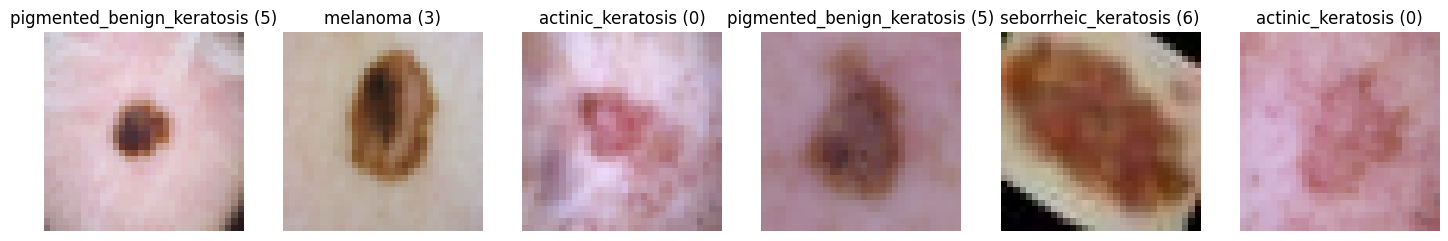

In [16]:
show_images(X_train, Y_train, label_map, num_images=6, mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Nếu ảnh RGB

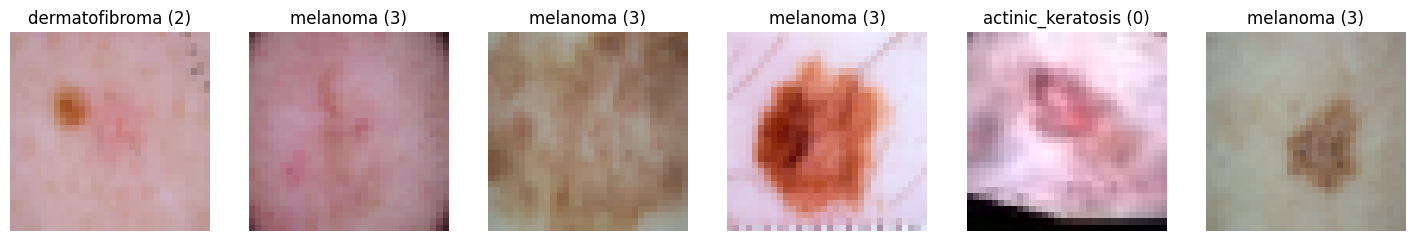

In [17]:
show_images(X_val, Y_val, label_map, num_images=6, mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Nếu ảnh RGB

In [18]:
def one_hot_tensor(Y):
    """
    Chuyển đổi nhãn số thành tensor one-hot.

    Args:
        Y (list, numpy array, hoặc torch.Tensor): Tensor nhãn số (N,)

    Returns:
        torch.Tensor: Tensor one-hot encoding có dạng (N, num_classes)
    """
    # Chuyển Y về tensor nếu chưa phải
    if isinstance(Y, (list, tuple)):
        Y = torch.tensor(Y, dtype=torch.long)
    elif not isinstance(Y, torch.Tensor):
        Y = torch.from_numpy(Y).long()

    # Kiểm tra và đảm bảo Y không chứa giá trị âm
    assert torch.all(Y >= 0), "Lỗi: Y chứa giá trị âm, không thể one-hot encode."

    # Xác định số lớp (num_classes)
    num_classes = int(Y.max().item() + 1)  # Lấy lớp lớn nhất +1

    # Tạo one-hot encoding bằng F.one_hot (hiệu suất cao hơn)
    one_hot = F.one_hot(Y, num_classes=num_classes).float()

    return one_hot

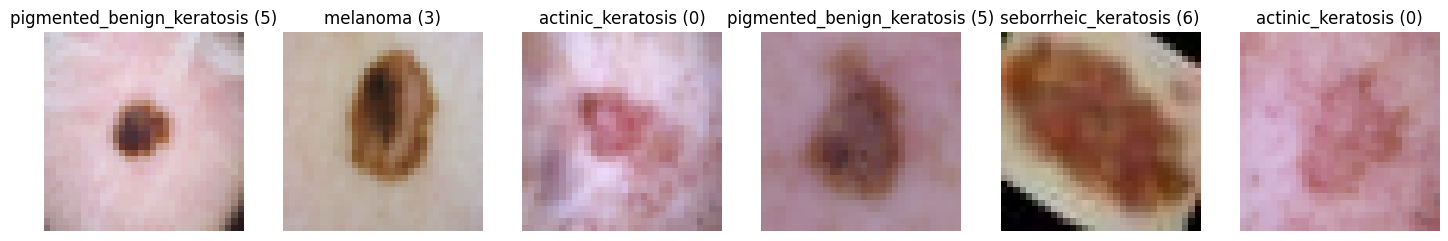

tensor([0., 0., 0., 0., 0., 1., 0., 0., 0.])


In [19]:
def show_images_with_one_hot(images, one_hot_labels, label_map, num_images=10, mean=[0.5], std=[0.5]):
    """
    Hiển thị ảnh và kiểm tra nhãn từ one-hot encoding.

    Args:
        images (torch.Tensor, numpy.ndarray): Ảnh đầu vào có dạng (N, C, H, W)
        one_hot_labels (torch.Tensor): One-hot encoded labels có dạng (N, num_classes)
        label_map (dict): Ánh xạ index -> tên lớp (e.g., {"melanoma": 0, "nevus": 1})
        num_images (int): Số lượng ảnh hiển thị
        mean (list): Mean dùng để chuẩn hóa ảnh
        std (list): Std dùng để chuẩn hóa ảnh
    """
    if isinstance(images, torch.Tensor):
        images = images.numpy()  # Chuyển tensor thành numpy

    num_images = min(num_images, len(images))  # Đảm bảo không hiển thị quá nhiều ảnh
    fig, axes = plt.subplots(1, num_images, figsize=(18, 6))
    
    if num_images == 1:
        axes = [axes]  # Đảm bảo `axes` là danh sách

    for i in range(num_images):
        img = images[i]
        img = img * np.array(std).reshape(-1, 1, 1) + np.array(mean).reshape(-1, 1, 1)  # Hủy chuẩn hóa
        img = np.clip(img, 0, 1)  # Giữ ảnh trong phạm vi [0,1]
        img = img.transpose(1, 2, 0)  # Chuyển tensor (C, H, W) -> (H, W, C)

        label_idx = torch.argmax(one_hot_labels[i]).item()  # Lấy nhãn từ one-hot
        label_name = [k for k, v in label_map.items() if v == label_idx][0]  # Tra nhãn
        
        axes[i].imshow(img)
        axes[i].set_title(f"{label_name} ({label_idx})")
        axes[i].axis("off")  # Ẩn trục tọa độ

    plt.show()
# Tạo one-hot labels từ Y_train
one_hot_train = one_hot_tensor(Y_train)

# Hiển thị ảnh và kiểm tra one-hot encoding
show_images_with_one_hot(X_train, one_hot_train, label_map, num_images=6, mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
print(one_hot_train[0])

In [20]:
# Normalize dữ liệu
X_train_norm = X_train
X_val_norm = X_val

Y_train_onehot = one_hot_tensor(Y_train)
Y_val_onehot= one_hot_tensor(Y_val)


# Kiểm tra kích thước dữ liệu sau khi xử lý
print("Train Image shape:", X_train_norm.shape)  # (số ảnh, 3, 64, 64)
print("Train Label shape:", Y_train_onehot.shape)  # (số ảnh,)
print("Val Image shape:", X_val_norm.shape)  # (số ảnh, 3, 64, 64)
print("Val Label shape:", Y_val_onehot.shape)  # (số ảnh,)


Train Image shape: torch.Size([3742, 3, 32, 32])
Train Label shape: torch.Size([3742, 9])
Val Image shape: torch.Size([510, 3, 32, 32])
Val Label shape: torch.Size([510, 9])


In [21]:
class Layer:
    def __init__(self, learning_rate=1e-3):
        self.cache_X = None
        self.learning_rate = learning_rate
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def forward(self, X):
        if not isinstance(X, torch.Tensor):
            X = torch.tensor(X, dtype=torch.float32, device=self.device)
        else:
            X = X.to(self.device)
        self.cache_X = X.clone()

    def backward(self, grad_in):
        raise NotImplementedError("The backward method must be implemented by subclasses.")


In [22]:
class Conv2D(Layer):
    def __init__(self, out_nchannel, dim, stride, pad, learning_rate=1e-3):
        super().__init__(learning_rate)
        self.out_nchannel = out_nchannel
        self.dim = dim
        self.stride = stride
        self.pad = pad
        
        self.W = None
        self.b = torch.zeros(out_nchannel, dtype=torch.float32, device=self.device)
        
        # Initialize Adam parameters
        self.mW, self.vW = None, None
        self.mb, self.vb = None, None
        self.beta1 = 0.9
        self.beta2 = 0.999
        self.epsilon = 1e-8
        self.t = 0

    def forward(self, X):
        X = X.to(self.device)
        super().forward(X)

        if self.W is None:
            self.W = torch.randn(
                (self.out_nchannel, X.shape[1], self.dim, self.dim),
                device=self.device
            ) * torch.sqrt(torch.tensor(2.0 / (self.out_nchannel + X.shape[1] * self.dim * self.dim), device=self.device))

        if self.pad > 0:
            X = F.pad(X, (self.pad, self.pad, self.pad, self.pad))

        batch_size, in_channels, height, width = X.shape
        out_height = (height - self.dim) // self.stride + 1
        out_width = (width - self.dim) // self.stride + 1
        WX = torch.zeros((batch_size, self.out_nchannel, out_height, out_width), dtype=torch.float32, device=self.device)

        for fh, h in enumerate(range(0, height - self.dim + 1, self.stride)):
            for fw, w in enumerate(range(0, width - self.dim + 1, self.stride)):
                region = X[:, :, h:h + self.dim, w:w + self.dim]
                WX[:, :, fh, fw] = torch.tensordot(region, self.W, dims=([1, 2, 3], [1, 2, 3]))
        
        return WX + self.b.view(1, -1, 1, 1)

    def backward(self, grad_in):
        X = self.cache_X
        batch_size, in_channels, height, width = X.shape

        dX = torch.zeros_like(X, dtype=torch.float32, device=self.device)
        dW = torch.zeros_like(self.W, dtype=torch.float32, device=self.device)
        db = torch.zeros_like(self.b, dtype=torch.float32, device=self.device)

        if self.pad > 0:
            X = F.pad(X, (self.pad, self.pad, self.pad, self.pad))

        dX_pad = torch.zeros_like(X, dtype=torch.float32, device=self.device)
        out_height, out_width = grad_in.shape[2], grad_in.shape[3]
        
        for fh in range(out_height):
            for fw in range(out_width):
                h_start, h_end = fh * self.stride, fh * self.stride + self.dim
                w_start, w_end = fw * self.stride, fw * self.stride + self.dim
                
                X_slice = X[:, :, h_start:h_end, w_start:w_end]
                grad_in_slice = grad_in[:, :, fh, fw].unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
                dX_pad[:, :, h_start:h_end, w_start:w_end] += (self.W.unsqueeze(0) * grad_in_slice).sum(dim=1)
                dW += (X_slice.unsqueeze(1) * grad_in_slice).sum(dim=0)
                db += grad_in_slice.sum(dim=(0, 2, 3, 4))

        if self.pad > 0:
            dX = dX_pad[:, :, self.pad:-self.pad, self.pad:-self.pad]
        else:
            dX = dX_pad

        # Adam optimizer updates
        if self.mW is None:
            self.mW = torch.zeros_like(self.W, dtype=torch.float32, device=self.device)
            self.vW = torch.zeros_like(self.W, dtype=torch.float32, device=self.device)
            self.mb = torch.zeros_like(self.b, dtype=torch.float32, device=self.device)
            self.vb = torch.zeros_like(self.b, dtype=torch.float32, device=self.device)

        self.t += 1
        
        # Compute biased first and second moment estimates
        self.mW = self.beta1 * self.mW + (1 - self.beta1) * dW
        self.vW = self.beta2 * self.vW + (1 - self.beta2) * (dW ** 2)
        mW_hat = self.mW / (1 - self.beta1 ** self.t)
        vW_hat = self.vW / (1 - self.beta2 ** self.t)
        self.W -= self.learning_rate * mW_hat / (torch.sqrt(vW_hat) + self.epsilon)
        
        self.mb = self.beta1 * self.mb + (1 - self.beta1) * db
        self.vb = self.beta2 * self.vb + (1 - self.beta2) * (db ** 2)
        mb_hat = self.mb / (1 - self.beta1 ** self.t)
        vb_hat = self.vb / (1 - self.beta2 ** self.t)
        self.b -= self.learning_rate * mb_hat / (torch.sqrt(vb_hat) + self.epsilon)

        return dX

In [23]:
class ReLU(Layer):
    def __init__(self):
        super().__init__()

    def forward(self, X):
        super().forward(X)
        return torch.where(self.cache_X > 0, self.cache_X, 0.01 * self.cache_X)

    def backward(self, grad_in):
        dX = grad_in.clone()
        dX[self.cache_X <= 0] *= 0.01
        return dX

In [24]:
class GeLU(Layer):
    def __init__(self, approximate=True):
        super().__init__()
        self.approximate = approximate

    def forward(self, X):
        super().forward(X)
        if self.approximate:
            return 0.5 * self.cache_X * (1 + torch.tanh(torch.sqrt(torch.tensor(2.0 / torch.pi)) * (self.cache_X + 0.044715 * self.cache_X**3)))
        else:
            return self.cache_X * 0.5 * (1 + torch.erf(self.cache_X / torch.sqrt(torch.tensor(2.0))))

    def backward(self, grad_in):
        if self.cache_X is None:
            raise ValueError("No forward pass has been executed. Cache is empty.")

        X = self.cache_X
        if self.approximate:
            tanh_term = torch.tanh(torch.sqrt(torch.tensor(2.0 / torch.pi)) * (X + 0.044715 * X**3))
            grad_tanh = 1 - tanh_term**2
            grad_approx = 0.5 * (1 + tanh_term) + 0.5 * X * grad_tanh * torch.sqrt(torch.tensor(2.0 / torch.pi)) * (1 + 3 * 0.044715 * X**2)
            return grad_in * grad_approx
        else:
            erf_term = torch.erf(X / torch.sqrt(torch.tensor(2.0)))
            exp_term = torch.exp(-X**2 / 2) / torch.sqrt(torch.tensor(2.0 * torch.pi))
            grad_exact = 0.5 * (1 + erf_term) + X * exp_term
            return grad_in * grad_exact


In [25]:
class BatchNorm(Layer):
    def __init__(self, num_features, epsilon=1e-5, momentum=0.9, learning_rate=1e-3):
        super().__init__(learning_rate)
        self.num_features = num_features
        self.epsilon = epsilon
        self.momentum = momentum

        # Scale gamma để đảm bảo output trong khoảng [-1,1]
        self.gamma = torch.full((1, num_features, 1, 1), 2.0, dtype=torch.float32, device=self.device)
        self.beta = torch.full((1, num_features, 1, 1), -1.0, dtype=torch.float32, device=self.device)

        # Running statistics
        self.running_mean = torch.zeros((1, num_features, 1, 1), dtype=torch.float32, device=self.device)
        self.running_var = torch.ones((1, num_features, 1, 1), dtype=torch.float32, device=self.device)

        self.cache = None

    def forward(self, X, training=True):
        X = X.to(self.device)
        if training:
            batch_mean = X.mean(dim=(0, 2, 3), keepdim=True)
            batch_var = X.var(dim=(0, 2, 3), keepdim=True, unbiased=False)
            X_hat = (X - batch_mean) / torch.sqrt(batch_var + self.epsilon)

            # Scale về khoảng [-1,1]
            out = self.gamma * X_hat + self.beta

            # Cập nhật running mean và variance
            self.running_mean = self.momentum * self.running_mean + (1 - self.momentum) * batch_mean.detach()
            self.running_var = self.momentum * self.running_var + (1 - self.momentum) * batch_var.detach()
            self.cache = (X, X_hat, batch_mean, batch_var)
        else:
            X_hat = (X - self.running_mean) / torch.sqrt(self.running_var + self.epsilon)
            out = self.gamma * X_hat + self.beta

        return out

    def backward(self, grad_in):
        if self.cache is None:
            raise ValueError("No forward pass executed before backward.")
        X, X_hat, batch_mean, batch_var = self.cache
        N, C, H, W = X.shape

        # Gradient của gamma và beta
        dgamma = (grad_in * X_hat).sum(dim=(0, 2, 3), keepdim=True)
        dbeta = grad_in.sum(dim=(0, 2, 3), keepdim=True)

        # Gradient với X
        inv_std = 1.0 / torch.sqrt(batch_var + self.epsilon)
        dX_hat = grad_in * self.gamma
        dX = dX_hat * inv_std

        # Cập nhật gamma và beta
        self.gamma -= self.learning_rate * dgamma
        self.beta -= self.learning_rate * dbeta

        return dX


In [26]:
class Dropout(Layer):
    def __init__(self, drop_prob=0.5):
        super().__init__()
        self.drop_prob = drop_prob
        self.training = True

    def forward(self, X):
        super().forward(X)
        if self.training:
            self.mask = (torch.rand(X.shape, device=self.device) > self.drop_prob).float()
            return self.mask * X / (1 - self.drop_prob)
        else:
            return X

    def backward(self, grad_in):
        if self.training:
            return grad_in * self.mask / (1 - self.drop_prob)
        else:
            return grad_in


In [27]:
class MaxPool2D(Layer):
    def __init__(self, dim, stride):
        super().__init__()
        self.dim = dim
        self.stride = stride

    def forward(self, X):
        super().forward(X)
        batch_size, in_channels, height, width = X.shape
        dim, stride = self.dim, self.stride

        out_height = (height - dim) // stride + 1
        out_width = (width - dim) // stride + 1
        y = torch.zeros((batch_size, in_channels, out_height, out_width), device=self.device)

        for fh in range(out_height):
            for fw in range(out_width):
                h_start, h_end = fh * stride, fh * stride + dim
                w_start, w_end = fw * stride, fw * stride + dim
                region = X[:, :, h_start:h_end, w_start:w_end]
                y[:, :, fh, fw] = torch.amax(region, dim=(2, 3))
       
        return y


    def backward(self, grad_in):
        X = self.cache_X
        dim, stride = self.dim, self.stride
        batch_size, channels, height, width = X.shape
        dX = torch.zeros_like(X, dtype=torch.float32, device=self.device)

        out_height, out_width = grad_in.shape[2], grad_in.shape[3]

        for fh in range(out_height):
            for fw in range(out_width):
                h_start, h_end = fh * stride, fh * stride + dim
                w_start, w_end = fw * stride, fw * stride + dim
                region = X[:, :, h_start:h_end, w_start:w_end]
                region_flat = region.reshape(region.size(0), region.size(1), -1)
                max_indices = torch.argmax(region_flat, dim=2)

                mask = torch.zeros_like(region_flat, device=self.device)
                mask.scatter_(2, max_indices.unsqueeze(2), 1)
                mask = mask.view(region.size())

                dX[:, :, h_start:h_end, w_start:w_end] += mask * grad_in[:, :, fh, fw].unsqueeze(-1).unsqueeze(-1)
        
        return dX

In [28]:
class Flatten(Layer):
    def forward(self, X):
        super().forward(X)
        return X.view(X.shape[0], -1)

    def backward(self, grad_in):
        return grad_in.view(self.cache_X.shape)

In [29]:
class Dense(Layer):
    def __init__(self, out_dim, beta1=0.9, beta2=0.999, epsilon=1e-8, learning_rate=1e-3):
        super().__init__(learning_rate)
        self.out_dim = out_dim
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.t = 0

        self.W = None
        self.b = None
        self.mW = None
        self.vW = None
        self.mb = None
        self.vb = None

    def forward(self, X):
        super().forward(X)
        in_dim = X.shape[-1]
        if self.W is None:
            self.W = torch.randn((in_dim, self.out_dim), device=self.device) * torch.sqrt(torch.tensor(2.0 / (in_dim + self.out_dim), device=self.device))
            self.mW = torch.zeros_like(self.W, device=self.device)
            self.vW = torch.zeros_like(self.W, device=self.device)
        if self.b is None:
            self.b = torch.zeros((self.out_dim,), device=self.device)
            self.mb = torch.zeros_like(self.b, device=self.device)
            self.vb = torch.zeros_like(self.b, device=self.device)
        return X @ self.W + self.b

    def backward(self, grad_in):
        X = self.cache_X
        dX = grad_in @ self.W.T
        dW = X.T @ grad_in
        db = grad_in.sum(dim=0)

        self.t += 1
        self.mW = self.beta1 * self.mW + (1 - self.beta1) * dW
        self.vW = self.beta2 * self.vW + (1 - self.beta2) * (dW ** 2)
        mW_hat = self.mW / (1 - self.beta1 ** self.t)
        vW_hat = self.vW / (1 - self.beta2 ** self.t)

        self.mb = self.beta1 * self.mb + (1 - self.beta1) * db
        self.vb = self.beta2 * self.vb + (1 - self.beta2) * (db ** 2)
        mb_hat = self.mb / (1 - self.beta1 ** self.t)
        vb_hat = self.vb / (1 - self.beta2 ** self.t)

        self.W -= self.learning_rate * mW_hat / (torch.sqrt(vW_hat) + self.epsilon)
        self.b -= self.learning_rate * mb_hat / (torch.sqrt(vb_hat) + self.epsilon)

        return dX

In [30]:
def softmax(X, axis=-1, epsilon=1e-6):
    X_max = torch.max(X, dim=axis, keepdim=True).values
    e_x = torch.exp(X - X_max)
    sum_e_x = e_x.sum(dim=axis, keepdim=True) + epsilon
    return e_x / sum_e_x

class SoftmaxCrossEntropy(Layer):
    def __init__(self):
        super().__init__()
        self.cache_grad = None

    def forward(self, X, y):
        X = X.to(self.device)
        y = y.to(self.device)
        super().forward(X)
        m = X.shape[0]

        if y.dim() == 1 or y.shape[1] == 1:
            y = torch.nn.functional.one_hot(y, num_classes=X.shape[1]).float()

        y_hat = softmax(X, axis=1)
        loss = -torch.mean(torch.sum(y * torch.log(y_hat + 1e-6), dim=1))
        self.cache_grad = (y_hat - y) / m
        return y_hat, loss

    def backward(self, grad_in):
        return self.cache_grad * grad_in

In [32]:
class Model:
    def __init__(self, layers, learn_rate=1e-3):
        self.layers = layers
        self.learn_rate = learn_rate
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        for layer in self.layers:
            layer.learn_rate = learn_rate

    def forward(self, X, y=None):
        X = X.to(self.device)
        for layer in self.layers[:-1]:
            X = layer.forward(X)
        if y is None:
            return softmax(X, axis=-1)
        y = y.to(self.device)
        return self.layers[-1].forward(X, y)

    def backward(self):
        grad = 1
        for layer in reversed(self.layers):
            grad = layer.backward(grad)
        return grad

    def fit(self, X_train, y_train, X_validate, y_validate, epochs=1, batch_size=32):
        n_sample = len(X_train)
        n_batch = (n_sample - 1) // batch_size + 1
        train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

        for epoch in range(epochs):
            print(f"Epoch {epoch+1} ===================")
            with tqdm(total=n_batch) as t:
                tot_loss, tot_acc = 0, 0
                for i in range(n_batch):
                    batch = range(batch_size * i, min(batch_size * (i + 1), n_sample))
                    batch_x, batch_y = X_train[batch].to(self.device), y_train[batch].to(self.device)
                    y_hat, loss = self.forward(batch_x, batch_y)

                    if torch.isnan(loss) or torch.isinf(loss):
                        print("Loss is NaN or Inf, skipping batch!!!.")
                        continue

                    self.backward()
                    acc = torch.mean((torch.argmax(y_hat, dim=1) == torch.argmax(batch_y, dim=1)).float()).item()
                    tot_loss += loss.item()
                    tot_acc += acc

                    if (i + 1) % 32 == 0 or i + 1 == n_batch:
                        t.set_postfix({'avg_loss': tot_loss / (i + 1), 'avg_accuracy': tot_acc / (i + 1)})
                        t.update(i % 32 + 1)

            train_losses.append(tot_loss / n_batch)
            train_accuracies.append(tot_acc / n_batch)

            print("Validation:")
            val_y_hat, val_loss = self.evaluate(X_validate, y_validate, batch_size=batch_size)
            val_acc = (torch.argmax(val_y_hat, dim=1) == torch.argmax(y_validate, dim=1)).float().mean().item()
            val_losses.append(val_loss)
            val_accuracies.append(val_acc)
            print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_acc}")
            print(torch.argmax(val_y_hat, dim=1))
            print(metrics.classification_report(torch.argmax(y_validate, dim=1).cpu(), torch.argmax(val_y_hat, dim=1).cpu(), zero_division=1))

        self.plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies, epochs)
        self.plot_confusion_matrix(y_validate, torch.argmax(val_y_hat, dim=1))

    def evaluate(self, X, y, batch_size=32):
        y_pred, tot_loss = [], 0
        n_sample, n_batch = X.size(0), (X.size(0) - 1) // batch_size + 1
        with torch.no_grad():
            for i in tqdm(range(n_batch)):
                batch = range(batch_size * i, min(batch_size * (i + 1), n_sample))
                y_hat, loss = self.forward(X[batch].to(self.device), y[batch].to(self.device))
                y_pred.append(y_hat.cpu())
                tot_loss += loss.item()
        return torch.cat(y_pred), tot_loss / n_batch

    def predict(self, X, batch_size=32):
        y_pred, n_sample, n_batch = [], len(X), (len(X) - 1) // batch_size + 1
        for i in range(n_batch):
            batch = range(batch_size * i, min(batch_size * (i + 1), n_sample))
            y_pred.append(self.forward(X[batch].to(self.device)).cpu().detach())
        return torch.cat(y_pred, dim=0)

    def plot_metrics(self, train_losses, val_losses, train_accuracies, val_accuracies, epochs):
        epochs_range = range(1, epochs + 1)
        plt.figure(figsize=(12, 6))

        plt.subplot(1, 2, 1)
        plt.plot(epochs_range, train_losses, label='Train Loss', marker='o')
        plt.plot(epochs_range, val_losses, label='Validation Loss', marker='o')
        plt.title('Train vs Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(epochs_range, train_accuracies, label='Train Accuracy', marker='o')
        plt.plot(epochs_range, val_accuracies, label='Validation Accuracy', marker='o')
        plt.title('Train vs Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.tight_layout()
        plt.show()
        
    def plot_confusion_matrix(self, y_true, y_pred):
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title('Confusion Matrix')
        plt.show()

In [48]:
model = Model([
# Block 1
    # ---------------
    Conv2D(64, 3, 1, 1),
    GeLU(),
    # ReLU(),
    BatchNorm(64),
    # -----------------
    Conv2D(64, 3, 1, 1),
    GeLU(),
    # ReLU(),
    BatchNorm(64),
    # -----------------
    Conv2D(64, 3, 1, 1),
    GeLU(),
    # ReLU(),
    BatchNorm(64),
    MaxPool2D(2, 2),

# Block 2
    Conv2D(128, 3, 1, 1),
    GeLU(),
    # ReLU(),
    BatchNorm(128),
    
    Conv2D(128, 3, 1, 1),
    GeLU(),
    # ReLU(),
    BatchNorm(128),
    
    Conv2D(128, 3, 1, 1),
    GeLU(),
    # ReLU(),
    BatchNorm(128),
    MaxPool2D(2, 2),


# Flatten and Dense Layers
    Flatten(),
    Dense(512),
    GeLU(),
    # ReLU(),

    Dense(256),
    GeLU(),
    # ReLU(),

    Dense(128),
    GeLU(),
    # ReLU(),

    Dense(64),
    GeLU(),
    # ReLU(),

    Dense(16),
    GeLU(),
    # ReLU(),
    
# Output for 9 classes
    Dense(9),  
    SoftmaxCrossEntropy()],
    learn_rate=0.005
)

In [49]:
model.fit(X_train_norm, Y_train_onehot, X_val_norm, Y_val_onehot, epochs=20, batch_size=59)

Epoch 1 ===================


100%|██████████| 64/64 [01:14<00:00,  1.17s/it, avg_loss=2.06, avg_accuracy=0.224]


Validation:


100%|██████████| 9/9 [00:02<00:00,  3.33it/s]


Validation Loss: 1.9896304210027058, Validation Accuracy: 0.2803921699523926
tensor([5, 7, 3, 4, 8, 3, 5, 7, 3, 5, 3, 4, 3, 7, 4, 3, 5, 4, 7, 7, 5, 8, 3, 8,
        7, 4, 7, 3, 8, 6, 7, 8, 8, 7, 5, 7, 3, 7, 7, 5, 7, 7, 8, 0, 3, 8, 7, 4,
        7, 8, 7, 3, 4, 8, 7, 8, 7, 3, 7, 5, 8, 7, 5, 3, 4, 5, 8, 3, 7, 3, 7, 3,
        7, 3, 7, 3, 4, 5, 8, 7, 7, 8, 7, 3, 8, 7, 3, 7, 3, 5, 5, 7, 3, 5, 8, 7,
        8, 7, 5, 5, 7, 5, 3, 4, 7, 7, 8, 7, 3, 5, 7, 3, 7, 7, 5, 7, 7, 3, 5, 3,
        8, 3, 3, 7, 7, 2, 5, 3, 7, 5, 7, 3, 3, 8, 5, 7, 8, 7, 5, 7, 5, 8, 8, 7,
        5, 7, 7, 7, 3, 3, 4, 7, 7, 3, 7, 5, 8, 3, 8, 8, 5, 7, 7, 3, 8, 4, 7, 3,
        7, 3, 7, 7, 7, 8, 3, 3, 7, 5, 5, 3, 7, 7, 3, 8, 3, 5, 3, 5, 7, 7, 7, 7,
        7, 7, 8, 7, 7, 4, 7, 7, 7, 3, 7, 7, 8, 7, 5, 7, 8, 4, 3, 3, 7, 5, 7, 1,
        5, 5, 7, 7, 7, 7, 5, 8, 7, 8, 4, 8, 8, 3, 8, 7, 3, 5, 7, 3, 3, 5, 3, 5,
        8, 4, 8, 5, 3, 7, 7, 3, 7, 7, 7, 3, 5, 8, 3, 7, 4, 5, 7, 3, 5, 3, 8, 8,
        3, 5, 8, 8, 8, 7, 7, 8, 7, 7, 3, 7,

100%|██████████| 64/64 [01:14<00:00,  1.17s/it, avg_loss=1.79, avg_accuracy=0.337]


Validation:


100%|██████████| 9/9 [00:02<00:00,  3.48it/s]


Validation Loss: 1.9403264655007257, Validation Accuracy: 0.29019609093666077
tensor([5, 7, 6, 4, 7, 6, 5, 7, 3, 5, 6, 4, 6, 7, 4, 6, 7, 6, 7, 7, 5, 0, 1, 7,
        7, 4, 7, 6, 7, 5, 6, 7, 8, 4, 5, 5, 6, 7, 7, 7, 7, 7, 7, 0, 4, 8, 7, 5,
        7, 7, 7, 6, 4, 8, 7, 7, 7, 6, 6, 5, 8, 7, 7, 6, 4, 7, 5, 6, 7, 6, 5, 6,
        7, 1, 7, 6, 4, 5, 5, 7, 7, 8, 7, 6, 8, 7, 6, 7, 6, 5, 5, 4, 6, 7, 8, 6,
        8, 7, 7, 5, 0, 5, 4, 4, 7, 7, 8, 7, 6, 7, 5, 0, 7, 6, 7, 8, 7, 6, 7, 6,
        7, 6, 6, 5, 5, 6, 5, 6, 5, 7, 7, 4, 6, 7, 5, 7, 8, 5, 5, 7, 5, 8, 8, 7,
        5, 7, 7, 7, 6, 6, 6, 7, 7, 6, 7, 8, 7, 6, 8, 8, 5, 7, 7, 6, 8, 4, 7, 6,
        8, 4, 7, 7, 5, 5, 4, 4, 5, 7, 8, 6, 7, 5, 4, 7, 6, 5, 6, 5, 7, 7, 7, 7,
        4, 7, 8, 7, 0, 4, 7, 7, 5, 6, 7, 7, 5, 7, 5, 4, 7, 8, 6, 6, 7, 5, 7, 7,
        5, 8, 7, 7, 7, 7, 5, 8, 8, 8, 6, 8, 7, 6, 8, 6, 6, 5, 4, 6, 6, 7, 6, 8,
        8, 4, 8, 7, 4, 7, 7, 6, 7, 7, 0, 6, 5, 7, 6, 7, 4, 8, 7, 6, 5, 6, 8, 8,
        6, 5, 8, 6, 8, 7, 7, 5, 7, 7, 3, 5

100%|██████████| 64/64 [01:14<00:00,  1.16s/it, avg_loss=1.64, avg_accuracy=0.409]


Validation:


100%|██████████| 9/9 [00:02<00:00,  3.46it/s]


Validation Loss: 2.0460470649931164, Validation Accuracy: 0.33137255907058716
tensor([5, 5, 3, 4, 7, 3, 5, 7, 4, 5, 3, 5, 6, 7, 4, 6, 5, 6, 5, 7, 5, 5, 5, 7,
        7, 4, 7, 6, 7, 5, 0, 7, 7, 0, 5, 5, 3, 7, 5, 5, 7, 5, 5, 7, 4, 8, 7, 5,
        7, 7, 7, 3, 4, 8, 7, 7, 7, 6, 7, 5, 8, 7, 5, 4, 4, 5, 7, 3, 5, 6, 5, 6,
        5, 4, 7, 3, 4, 5, 5, 7, 5, 8, 5, 6, 8, 7, 3, 7, 3, 5, 5, 7, 3, 5, 5, 6,
        8, 5, 5, 5, 7, 5, 5, 4, 5, 7, 8, 5, 3, 5, 5, 2, 7, 6, 7, 5, 7, 0, 5, 3,
        7, 3, 3, 6, 5, 0, 5, 3, 5, 5, 5, 4, 6, 7, 5, 5, 7, 5, 5, 5, 5, 7, 7, 7,
        5, 7, 5, 7, 6, 6, 3, 5, 7, 6, 7, 5, 0, 3, 8, 8, 5, 5, 7, 6, 6, 4, 7, 3,
        7, 4, 5, 5, 5, 5, 4, 4, 5, 7, 5, 3, 0, 5, 4, 7, 3, 5, 3, 5, 7, 7, 7, 5,
        5, 7, 8, 5, 7, 4, 7, 7, 5, 6, 5, 7, 5, 7, 5, 4, 8, 5, 3, 3, 7, 5, 7, 7,
        5, 5, 7, 7, 7, 5, 5, 8, 7, 5, 6, 8, 7, 6, 8, 7, 3, 5, 0, 3, 6, 5, 3, 8,
        5, 4, 5, 5, 4, 5, 5, 3, 5, 5, 7, 3, 5, 7, 3, 7, 4, 5, 7, 3, 5, 6, 5, 0,
        3, 5, 7, 4, 8, 7, 5, 5, 7, 7, 3, 5

  0%|          | 0/64 [00:13<?, ?it/s]


KeyboardInterrupt: 